# FORESEE Models: U(1)B Gauge Boson

## Load Libraries 

In [1]:
import numpy as np
import sys
import os
src_path = "/Users/felixkling/Documents/GitHub/FORESEE/"
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model
from matplotlib import pyplot as plt

## 1. Specifying the Model

The phenomenology of the U(1)B gauge boson $A'$ can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = \frac{1}{2} \color{red}{m_{A'}}^2 X'^2  - \color{red}{g_{B}} \sum x_{f}\bar f \gamma^\mu f X'_\mu
\end{equation}

with the $U(1)_{B}$ gauge boson mass $m_{A'}$ and the coupling strength to fermion $g_{B}$ as free parameters. The parameters $x_{f}$ specify the baryon minus lepton number of different fermions, in this case $x_{u}$ = $x_{d}$=1/3 and $x_{e}$ = $x_{\nu}$ = -1 for all three generations.  

In [2]:
energy = "13.6"
modelname="U(1)B"
model = Model(modelname, path="./")

**Production:** If the U(1)B gauge boson is sufficiently light, it is primarily produced in the decay of pseudoscalar mesons $\pi^0$, $\eta$, $\eta' \to A' \gamma$. The branching fractions can be found in Tab. 3 of [1801.04847](https://arxiv.org/pdf/1801.04847.pdf). We find

\begin{align}
    \text{BR}(\pi^0 \to X \gamma) &= 2 (g_B/e)^2 \times \left(1-m_{X}^2/m_\pi^2\right)^3\times\text{BR}(\pi^0 \to \gamma\gamma)|{\rm BW}_{\omega}(m_X^2)|^2  \\
    \text{BR}(\eta \to X \gamma) &= \frac{1}{16} (g_B/e)^2  \times \left(1-m_{X}^2/m_\eta^2\right)^3 \times\text{BR}(\eta \to \gamma\gamma) |{\rm BW}_{\omega}+{\rm BW}_{\phi}|^2 \\
    \text{BR}(\eta' \to X \gamma) &= \frac{1}{49} (g_B/e)^2 \times \left(1-m_{X}^2/m_{\eta'}^2\right)^3\times\text{BR}(\eta' \to \gamma\gamma)  \times |{\rm BW}_{\omega}-2{\rm BW}_{\phi}|^2
\end{align}

where ${\rm BW}_{V}=(1-m_{A'}^2/m_V^2 - i \Gamma_V/m_V )^{-1}$. In the following, we model the production using `EPOSLHC`, `SIBYLL`, `QGSJET`, and `Pythia8-Forward`.  **DOUBLE CHECK** 

In [3]:
model.add_production_2bodydecay(
    pid0 = "111",
    pid1 = "22",
    br = "2*0.99 * (coupling/0.3)**2 * pow(1.-pow(mass/self.masses('111'),2),3)*np.abs((1-mass**2/0.78265**2 - 0.00849/0.78265*1j)**(-1))**2",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
    nsample = 100
)

model.add_production_2bodydecay(
    pid0 = "221",
    pid1 = "22",
    br = "1./16*0.3941 * (coupling/0.3)**2 * pow(1.-pow(mass/self.masses('221'),2),3)*np.abs((1-mass**2/0.78265**2 - 0.00849/0.78265*1j)**(-1)+(1-mass**2/1.019461**2-0.004249/1.019461*1j)**(-1))**2",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
    nsample = 100
)

model.add_production_2bodydecay(
    pid0 = "331",
    pid1 = "22",
    br = "1./49.*0.02307 * (coupling/0.3)**2 * pow(1.-pow(mass/self.masses('331'),2),3) * np.abs((1-mass**2/0.78265**2 - 0.00849/0.78265*1j)**(-1) - 2*(1-mass**2/1.019461**2-0.004249/1.019461*1j)**(-1))**2",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
    nsample = 100
)

We can also produce the U(1)B boson via it's resonant mixing with the SM vector mesons, in this case only the $\omega$ and $\phi$ mesons. Following [arXiv:1810.01879](https://arxiv.org/pdf/1810.01879.pdf) and [arXiv:1801.04847](https://arxiv.org/abs/1801.04847), we can write 

\begin{equation}
    \sigma(V) = \theta_V^2 \  \sigma(V)
    \quad\quad\text{with}\quad\quad
    \theta_V = \frac{f_v \times g}{g_V}  \frac{m_V^2}{m_{X}^2 - m_V^2 + i m_V \Gamma_V}
\end{equation}

Here $g_\omega = 17$, $g_\phi=-12.88$, $f_\omega=4$ and $f_\phi=1$. We can specify this production mode using `model.add_production_mixing()`. Since the $\rho$ contribution is absent in the $U(1)_B$ model, we use both other mixing terms.

In [4]:
model.add_production_mixing(
    pid = "223",
    mixing = "coupling * 4./17. * 0.78265**2/abs(mass**2-0.78265**2+0.78265*0.00849*1j)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
)

model.add_production_mixing(
    pid = "333",
    mixing = "coupling /12.88 * 1.019461**2/abs(mass**2-1.019461**2+1.019461*0.004249*1j)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
)

The $U(1)_{B}$ can also be produced via dark Bremsstrahlung, so coherent radiation off a proton in processes such as $p p \to p p X'$. The spectra for LLPs have been obtained following the FWW approximation described in [1708.09389](https://arxiv.org/abs/1708.09389), rescaled by ($g_{B}/\epsilon e)^2$ (achieved by setting the reference coupling to $g_{B,ref} = e$ as derived in [1803.05466](https://arxiv.org/abs/1803.05466), and are provided in the `files/direct` directory. As the FWW apprixmation loose validaty at high pT, we impose a cut on the pT of the dark photon and study the associated uncertainy by varing that cut as `0.5`, `1`, `2` GeV.

In [5]:
masses_brem = [ 
    0.01  ,  0.0126,  0.0158,  0.02  ,  0.0251,  0.0316,  0.0398,
    0.0501,  0.0631,  0.0794,  0.1   ,  0.1122,  0.1259,  0.1413,
    0.1585,  0.1778,  0.1995,  0.2239,  0.2512,  0.2818,  0.3162,
    0.3548,  0.3981,  0.4467,  0.5012,  0.5623,  0.6026,  0.631 ,
    0.6457,  0.6607,  0.6761,  0.6918,  0.7079,  0.7244,  0.7413,
    0.7586,  0.7762,  0.7943,  0.8128,  0.8318,  0.8511,  0.871 ,
    0.8913,  0.912 ,  0.9333,  0.955 ,  0.9772,  1.    ,  1.122 ,
    1.2589,  1.4125,  1.5849,  1.7783,  1.9953,  2.2387,  2.5119,
    2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 10.    
]

model.add_production_direct(
    label = "Brem",
    energy = energy,
    condition = ["p.pt<1", "p.pt<2", "p.pt<0.5"],
    coupling_ref=0.303,
    masses = masses_brem,
)

**Decay:** The $U(1)_{B-L}$ gauge boson can decay into a varity of light states. Here we use the lifetime and the decay branching fractions as presented in [1801.04847](https://arxiv.org/pdf/1801.04847.pdf) for the DarkCast tool.

In [6]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
)

decay_modes = ["ee", "mumu", "pigamma", "3pi", "KK"] 
model.set_br_1d(
    modes = decay_modes,
    finalstates=[[11,-11], [13,-13], [111,22], [211,-211,111], [321,-321]],
    filenames=["model/br/"+mode+".txt" for mode in decay_modes],
)

We can now initiate FORESEE with the model that we just created. 

In [7]:
foresee = Foresee(path=src_path)
foresee.set_model(model=model)

## 2. Event Generation

In the following, we want to study one specific benchmark point with $m_{A'}=300$ MeV and $\epsilon=2\cdot10^{-4}$ and export events as a HEPMC file. 

In [8]:
mass, coupling, = 0.3, 2e-4

First, we will produce the corresponding flux for this mass and a reference coupling $\epsilon_{ref}=1$. 

save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_EPOSLHC_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_SIBYLL_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_QGSJET_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_EPOSLHC_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_SIBYLL_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_QGSJET_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.3.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_0.3.npy
save data to file: ./model/LLP_spectra/13.

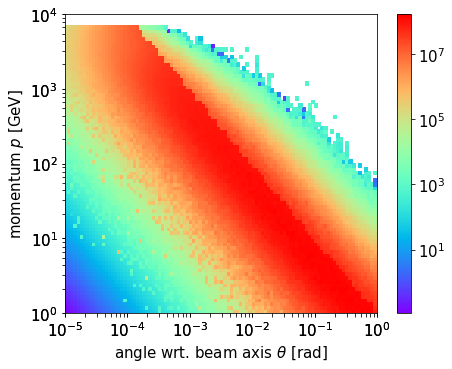

In [9]:
plot=foresee.get_llp_spectrum(mass=mass, coupling=1, do_plot=True)
plot.show()

Next, let us define the configuration of the detector (in terms of position, size and luminosity). Here we choose FASER during 2022/2023 and require the decay channel $A' \to \pi^0 \gamma \to 3\gamma$. 

In [11]:
foresee.set_detector(
    distance=474, 
    selection="np.sqrt(x.x**2 + (x.y+0.065)**2)<.1", 
    length=3.5, 
    luminosity=60, 
    channels=['pigamma'],
)

For our benchmark point, let us now look at how many particle decay inside the decay volume. We also export 1000 unweighted events as a HEPMC file. 

In [12]:
setupnames = ['EPOSLHC_pT=1', 'SIBYLL_pT=2', 'QGSJET_pT=0.5']
modes = {'111': ['EPOSLHC', 'SIBYLL', 'QGSJET'], 
         '221':['EPOSLHC', 'SIBYLL', 'QGSJET'], 
         "Brem": ["p.pt<1", "p.pt<2", "p.pt<0.5"]}

momenta, weights, _ = foresee.write_events(
    mass = mass, 
    coupling = coupling, 
    energy = energy, 
    numberevent = 1000,
    filename = "model/events/test.hepmc", 
    return_data = True,
    weightnames=setupnames,
    modes=modes,
)

for isetup, setup in enumerate(setupnames):
    print("Expected number of events for "+setup+":", round(sum(weights[:,isetup]),3))

Expected number of events for EPOSLHC_pT=1: 4064.922
Expected number of events for SIBYLL_pT=2: 4874.826
Expected number of events for QGSJET_pT=0.5: 1881.255


Let us plot the resulting energy distribution

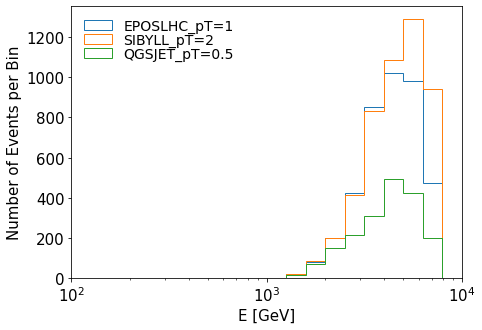

In [13]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
energies = [p.e for p in momenta], 
for isetup, setup in enumerate(setupnames):
    ax.hist(energies, weights=weights[:,isetup], bins=np.logspace(2,4, 20+1), histtype='step', label=setup) 
ax.set_xscale("log")
ax.set_xlim(1e2,1e4) 
ax.set_xlabel("E [GeV]") 
ax.set_ylabel("Number of Events per Bin") 
ax.legend(frameon=False, labelspacing=0, fontsize=14, loc='upper left')
plt.show()

## 3. Sensitivity Reach

In the following, we will obtain the projected sensitivity for the LLP model. For this, we first define a grid of couplings and masses, and then produce the corresponding fluxes. 

In [14]:
masses=[round(x,5) for x in np.logspace(-1,0.2,22+1)]
couplings = np.logspace(-8,-3,101) 

for mass in masses: foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_SIBYLL_m_0.01.npy
save data to file: ./model/LL

save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_EPOSLHC_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_SIBYLL_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_QGSJET_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_EPOSLHC_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_SIBYLL_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_QGSJET_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<0.5_m_0.03981.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBY

save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_EPOSLHC_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_SIBYLL_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_QGSJET_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_EPOSLHC_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_SIBYLL_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_QGSJET_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.19953.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_

save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_1.25893.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_1.25893.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<0.5_m_1.25893.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_EPOSLHC_m_1.58489.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_SIBYLL_m_1.58489.npy
save data to file: ./model/LLP_spectra/13.6TeV_223_QGSJET_m_1.58489.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_EPOSLHC_m_1.58489.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_SIBYLL_m_1.58489.npy
save data to file: ./model/LLP_spectra/13.6TeV_333_QGSJET_m_1.58489.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_1.58489.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_1.58489.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<0.5_m_1.58489.npy


We can now plot the `production rate vs mass` using the `foresee.plot_production()` function.

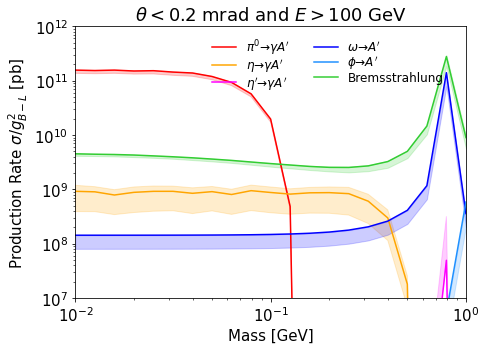

In [15]:
productions=[
    {"channels": ["111"] , "color": "red"       , "label": r"$\pi^0 \to \gamma A'$", "generators": ["EPOSLHC","QGSJET","SIBYLL",'Pythia8-Forward']   },
    {"channels": ["221"] , "color": "orange"    , "label": r"$\eta \to \gamma A'$" , "generators": ["EPOSLHC","QGSJET","SIBYLL",'Pythia8-Forward']   },
    {"channels": ["331"] , "color": "magenta"   , "label": r"$\eta' \to \gamma A'$", "generators": ["EPOSLHC","SIBYLL",'Pythia8-Forward']            },
    {"channels": ["223"] , "color": "blue"      , "label": r"$\omega \to A'$"      , "generators": ["EPOSLHC","SIBYLL",'Pythia8-Forward']            },
    {"channels": ["333"] , "color": "dodgerblue", "label": r"$\phi \to A'$"        , "generators": ["EPOSLHC","SIBYLL",'Pythia8-Forward']            },
    {"channels": ["Brem"], "color": "limegreen" , "label": r"Bremsstrahlung"       , "generators": ["p.pt<1", "p.pt<2", "p.pt<0.5"]},
]

plot=foresee.plot_production(
    masses = masses,
    productions = productions,
    energy=energy,
    condition="logth<-3.7 and logp>2",  
    xlims=[0.01,1],ylims=[1e7,1e12],
    xlabel=r"Mass [GeV]",
    ylabel=r"Production Rate $\sigma/g_{B-L}^2$ [pb]",
    title=r"$\theta < 0.2$ mrad and $E > 100$ GeV",
    legendloc=(0.97,1),
    fs_label=12,
    ncol=2,
)

Let us now scan over various masses and couplings, and record the resulting number of evets. Note that here we again consider the FASER configuration, which we set up before.

In [16]:
#get reach  
list_nevents = {label:[] for label in setupnames}
for mass in masses:
    couplings, _, nevents, _, _  = foresee.get_events(mass=mass, energy=energy, couplings = couplings,modes=modes)
    for i,label in enumerate(setupnames): list_nevents[label].append(nevents.T[i])  
        
#save results
configuration='default'
for label in setupnames: 
    result = np.array([masses,couplings,list_nevents[label]], dtype='object')
    np.save("model/results/"+energy+"TeV_"+configuration+"_"+label+".npy",result)

We can now plot the results. For this, we first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [17]:
setups = [ 
    ["13.6TeV_default_EPOSLHC_pT=1.npy",  "EPOS / pT=1"    , "red"        ,  "solid"  , 0., 3],
    ["13.6TeV_default_SIBYLL_pT=2.npy" ,  "SYBILL / pT=2"  , "magenta"    ,  "solid"  , 0., 3],
    ["13.6TeV_default_QGSJET_pT=0.5.npy" ,"QGSJET / pT=0.5", "orange"     ,  "solid"  , 0., 3],
]

Then we specify all the existing bounds, separating the bounds obtained by experimental collaboratios and theory recasts. **Separae Anomaly KZB constraints** **Add missing constraints**

In [18]:
bounds = [   
    ["bounds_LSND.txt",     "LSND",          0.200,  2.5*10**-7, 0  ],
    ["bounds_E137.txt",     "E137",          0.1600, 0.6*10**-4, 0  ],
    ["bounds_PS191.txt",    "PS191",         0.11,   1*10**-5  , 0  ],
    ["bounds_CHARM.txt",    "CHARM",         0.300,  0.8*10**-6, 0  ],
    ["bounds_NuCal.txt",    "NuCal",         0.600,  0.8*10**-6, 0  ],
    ["bounds_LHCb-mumu.txt","$LHCb-\mu\mu$", 0.350,  1*10**-3  , 0  ],
    ["bounds_NA48.txt",     "NA48",          0.110,  1*10**-2  , 0  ],
    ["bounds_KLOEII.txt",   "KLOE II",       0.240,  3*10**-2  , 0  ],
]

bounds2 = [     
    ["bounds_B-_KZB.txt",   r"Anomaly", 0.700, 0.9*10**-2, 0],
]

We also want to show the branching fractions for some of the channels (name of file in model/br directory, color, line style, label, x-position, y-position)  

In [19]:
branchings = [
    ["pigamma", "black"        , "solid" , r"$\pi\gamma$"         , 0.225, 0.50],
    ["3pi"    , "red"          , "solid" , r"$\pi^+\pi^-\pi^0$"   , 0.525, 0.03],
    ["KK"     , "magenta"      , "solid" , r"$KK$"                , 0.905, 0.03],
    ["ee"     , "blue"         , "solid" , r"$ee$"                , 0.110, 0.50],
    ["mumu"   , "dodgerblue"   , "solid" , r"$\mu\mu$"            , 0.205, 0.013],
]

Finally, we can plot everything using `foresee.plot_reach()`. Here we also add the dark matter relict target line obtained in [2105.07077](https://arxiv.org/abs/2105.07077).

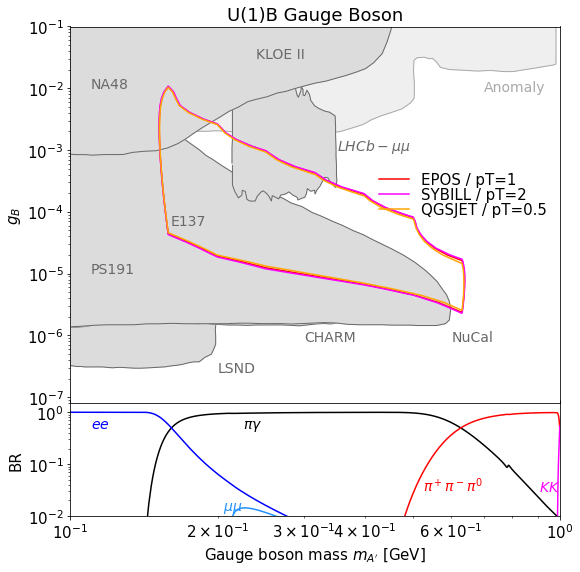

In [27]:
plot, ax, ax2 = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    bounds2=bounds2,
    projections=[],
    title = "U(1)B Gauge Boson", 
    xlims = [0.1,1], 
    ylims = [8e-8,1e-1],
    xlabel=r"Gauge boson mass $m_{A'}$ [GeV]", 
    ylabel=r"$g_{B}$" ,
    legendloc=(1.00,0.650),
    branchings=branchings,
    figsize=(8,8),
)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.show()